In [1]:
energy = 0.9
pressure= .004
radius = 3
tempSpike = 100

In [2]:
import numpy as np
import hoomd
import fresnel
import matplotlib.pyplot as plt
import scipy
import h5py
import gsd.hoomd
import itertools
import math
import time
import os
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
# This is not intended as a full tutorial on fresnel - see the
# fresnel user documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box
    
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 192 / 255, 203 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L[0], L[1], L[2], 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L[0] * 2, L[1], L[2] * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L[2] * 1.4 + 1)
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [4]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename="longerRun"+str(tempSpike)+"energy"+str(energy)+"r"+str(radius)+".gsd")

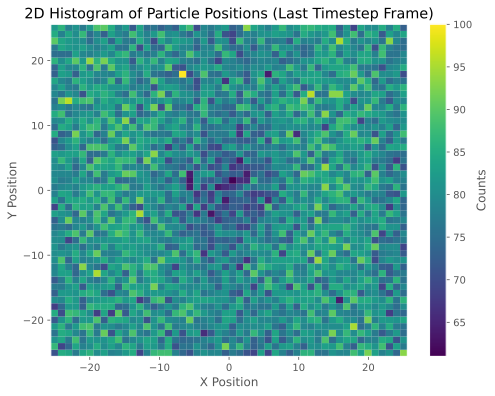

In [5]:
with gsd.hoomd.open("longerRun"+str(tempSpike)+"energy"+str(energy)+"r"+str(radius)+".gsd", 'r') as f:
    num_frames = len(f)
    last_frame = f[num_frames - 1]

positions = last_frame.particles.position[:, :2]  # get x, y

positions = np.array(positions)

plt.figure(figsize=(8, 6))
plt.hist2d(positions[:, 0], positions[:, 1], bins=50, cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('2D Histogram of Particle Positions (Last Timestep Frame)')
plt.show()


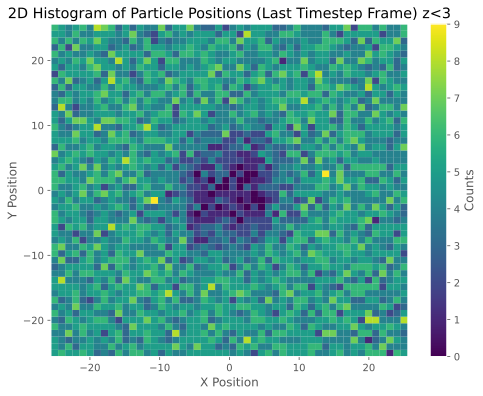

In [6]:
# last frame is at last time step
with gsd.hoomd.open("longerRun"+str(tempSpike)+"energy"+str(energy)+"r"+str(radius)+".gsd", 'r') as f:
    num_frames = len(f)
    last_frame = f[num_frames - 1]

positions = last_frame.particles.position[np.abs(last_frame.particles.position[:, 2]) < 3] # get x, y

positions = np.array(positions)

plt.figure(figsize=(8, 6))
plt.hist2d(positions[:, 0], positions[:, 1], bins=50, cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('2D Histogram of Particle Positions (Last Timestep Frame) z<3')
plt.show()

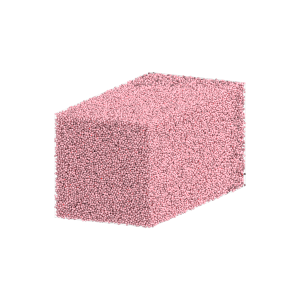

In [7]:
render(simulation.state.get_snapshot())
#what pressure and temp does it end at
    # make lennard-jones plot with this info
#r3 14 superheated no bubble
# r6 T100 will hyppothetically need to run for longer
    # supercritical
    # if all bubbles; reduce r3t14 energy and size

In [8]:
 hdf5_file = h5py.File(name="longerRun"+str(tempSpike)+"energy"+str(energy)+"r"+str(radius)+".h5", mode='r')

In [9]:
pressure_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure'][:])
temperature_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/kinetic_temperature'][:])

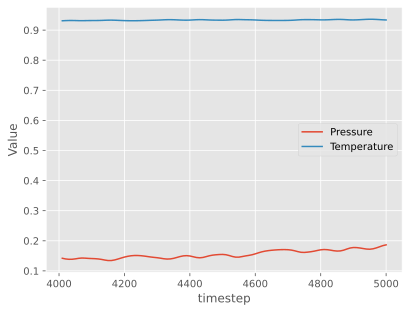

In [10]:
# pressure vs time
timesteps = np.float64(hdf5_file['hoomd-data/Simulation/timestep'][:])

plt.plot(timesteps, pressure_data, label='Pressure')
plt.plot(timesteps, temperature_data, label='Temperature')
plt.xlabel('timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

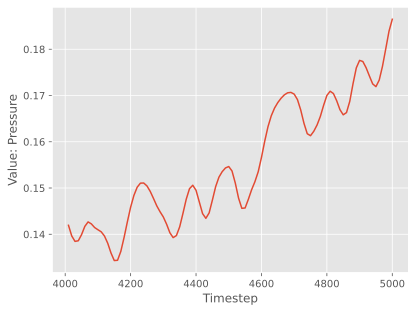

In [11]:
plt.plot(timesteps, pressure_data)
plt.xlabel('Timestep')
plt.ylabel('Value: Pressure')
plt.show()

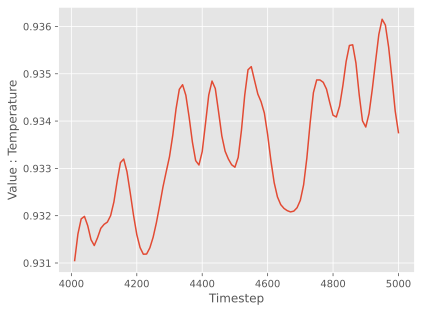

In [12]:
plt.plot(timesteps, temperature_data)
plt.xlabel('Timestep')
plt.ylabel('Value : Temperature')
plt.show()